<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_Assignment3/blob/main/Attention_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
!pip install --upgrade wandb
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 9.7 MB/s 
     |████████████████████████████████| 144 kB 52.7 MB/s 
     |████████████████████████████████| 181 kB 52.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=67966b74c8e6882e2eb55cd4e8256a542f457c31a7b45e9fc9f888f6b2c8e95e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#Download and unzip the Dakshina dataset 
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xf '/content/dakshina_dataset_v1.0.tar'

--2022-05-06 10:53:13--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   235MB/s    in 7.8s    

2022-05-06 10:53:21 (247 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
wandb.init(project="CS6910-Assignment_3-sweep-Tamil", entity="hithesh-sidhesh", name="Question_5")

wandb: Currently logged in as: hithesh (hithesh-sidhesh). Use `wandb login --relogin` to force relogin


In [ ]:
def load_data(path):
    with open(path) as fil:
        data = pd.read_csv(fil,sep='\t',header=None,names=["Tamil","English",""],skip_blank_lines=True,index_col=None)
    data = data[data['Tamil'].notna()]
    data = data[data['English'].notna()]
    data = data[['Tamil','English']]
    return data

train = load_data("/content/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv")
val = load_data("/content/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv")
test = load_data("/content/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv")


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 25  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

In [ ]:
x = train['English'].values
y = train['Tamil'].values
# We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
y = "\t"+y+"\n"

In [ ]:
train_input_words = [str(word) for word in list(train['English'])]
train_target_words = ["\t" + str(word) + "\n" for word in list(train['Tamil'])]

val_input_words = [str(word) for word in list(val['English'])]
val_target_words = ["\t" + str(word) + "\n" for word in list(val['Tamil'])]

test_input_words = [str(word) for word in list(test['English'])]
test_target_words = ["\t" + str(word) + "\n" for word in list(test['Tamil'])]

    # for train_word in train_input_words:
    #     for char in train_word:
    #         input_characters.add(char)

    # for val_word in val_input_words:
    #     for char in val_word:
    #         input_characters.add(char)

    # for test_word in test_input_words:
    #     for char in test_word:
    #         input_characters.add(char)

    # for train_word in train_target_words:
    #     for char in train_word:
    #         target_characters.add(char)

    # for val_word in val_target_words:
    #     for char in val_word:
    #         target_characters.add(char)

    # for test_word in test_target_words:
    #     for char in test_word:
    #         target_characters.add(char)

In [ ]:
input_characters = set()
target_characters = set()

for i in range(len(x)):
  input_characters.update(list(str(x[i])))
  target_characters.update(list(str(y[i])))

  # input_characters=list(set(input_characters+list(str(x[i]))))
  # target_characters=list(set(target_characters+list(str(y[i]))))

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

# add the space character to both
input_characters.append(" ")
target_characters.append(" ")

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

input_length=[]
target_length=[]
for i in range(len(x)):
  input_length.append(len(str(x[i])))
  target_length.append(len(str(y[i])))

max_encoder_seq_length = max(input_length)
max_decoder_seq_length = max(target_length)

print("Number of samples:", len(x))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print(input_token_index)
print(target_token_index)
encoder_input_data = np.zeros((len(x), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(x), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(x), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(x, y)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 68215
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26}
{'\t': 0, '\n': 1, 'ஃ': 2, 'அ': 3, 'ஆ': 4, 'இ': 5, 'ஈ': 6, 'உ': 7, 'ஊ': 8, 'எ': 9, 'ஏ': 10, 'ஐ': 11, 'ஒ': 12, 'ஓ': 13, 'க': 14, 'ங': 15, 'ச': 16, 'ஜ': 17, 'ஞ': 18, 'ட': 19, 'ண': 20, 'த': 21, 'ந': 22, 'ன': 23, 'ப': 24, 'ம': 25, 'ய': 26, 'ர': 27, 'ற': 28, 'ல': 29, 'ள': 30, 'ழ': 31, 'வ': 32, 'ஷ': 33, 'ஸ': 34, 'ஹ': 35, 'ா': 36, 'ி': 37, 'ீ': 38, 'ு': 39, 'ூ': 40, 'ெ': 41, 'ே': 42, 'ை': 43, 'ொ': 44, 'ோ': 45, 'ௌ': 46, '்': 47, ' ': 48}


In [ ]:
print(encoder_input_data.shape)

(68215, 30, 27)


In [ ]:
#Embedding validation data
x_val = val['English'].values
y_val = val['Tamil'].values
# We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
y_val = "\t"+y_val+"\n"

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
val_input_characters = set()
val_target_characters = set()

for i in range(len(x_val)):
  val_input_characters.update(list(str(x_val[i])))
  val_target_characters.update(list(str(y_val[i])))

  # input_characters=list(set(input_characters+list(str(x[i]))))
  # target_characters=list(set(target_characters+list(str(y[i]))))

val_input_characters = sorted(list(val_input_characters))
val_target_characters = sorted(list(val_target_characters))

# add the space character to both
val_input_characters.append(" ")
val_target_characters.append(" ")

val_num_encoder_tokens = len(val_input_characters)
val_num_decoder_tokens = len(val_target_characters)

val_input_length=[]
val_target_length=[]
for i in range(len(x_val)):
  val_input_length.append(len(str(x_val[i])))
  val_target_length.append(len(str(y_val[i])))

val_max_encoder_seq_length = max(val_input_length)
val_max_decoder_seq_length = max(val_target_length)

print("Number of samples in validation set:", len(x_val))
print("Number of unique input tokens:", val_num_encoder_tokens)
print("Number of unique output tokens:", val_num_decoder_tokens)
print("Max sequence length for validation inputs:", val_max_encoder_seq_length)
print("Max sequence length for valiation outputs:", val_max_decoder_seq_length)

val_input_token_index = dict([(char, i) for i, char in enumerate(val_input_characters)])
val_target_token_index = dict([(char, i) for i, char in enumerate(val_target_characters)])
print(val_input_token_index)
print(val_target_token_index)

val_encoder_input_data = np.zeros((len(x_val), val_max_encoder_seq_length,val_num_encoder_tokens), dtype="float32")
val_decoder_input_data = np.zeros((len(x_val), val_max_decoder_seq_length,val_num_decoder_tokens), dtype="float32")
val_decoder_target_data = np.zeros((len(x), max_decoder_seq_length, val_num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(x_val, y_val)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t ,input_token_index[char]] = 1.0
    val_encoder_input_data[i, t + 1 :,input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t ,target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :,target_token_index[" "]] = 1.0
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples in validation set: 6827
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for validation inputs: 23
Max sequence length for valiation outputs: 22
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26}
{'\t': 0, '\n': 1, 'ஃ': 2, 'அ': 3, 'ஆ': 4, 'இ': 5, 'ஈ': 6, 'உ': 7, 'ஊ': 8, 'எ': 9, 'ஏ': 10, 'ஐ': 11, 'ஒ': 12, 'ஓ': 13, 'க': 14, 'ங': 15, 'ச': 16, 'ஜ': 17, 'ஞ': 18, 'ட': 19, 'ண': 20, 'த': 21, 'ந': 22, 'ன': 23, 'ப': 24, 'ம': 25, 'ய': 26, 'ர': 27, 'ற': 28, 'ல': 29, 'ள': 30, 'ழ': 31, 'வ': 32, 'ஷ': 33, 'ஸ': 34, 'ஹ': 35, 'ா': 36, 'ி': 37, 'ீ': 38, 'ு': 39, 'ூ': 40, 'ெ': 41, 'ே': 42, 'ை': 43, 'ொ': 44, 'ோ': 45, 'ௌ': 46, '்': 47, ' ': 48}


In [ ]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_data = np.argmax(encoder_input_data, axis=2)
val_encoder_input_data = np.argmax(val_encoder_input_data, axis=2)
#test_encoder_input_data = np.argmax(test_encoder_input_data, axis=2)
print(encoder_input_data.shape)

AxisError: ignored

In [ ]:
decoder_input_data = np.argmax(decoder_input_data, axis=2)
val_decoder_input_data = np.argmax(val_decoder_input_data, axis=2)
#test_decoder_input_data = np.argmax(test_decoder_input_array, axis=2)

In [ ]:
#Build the model
def create_model(num_encoder_tokens,embedding_size,cell_type,latent_dimension,dropout,number_of_encoder_layers,num_decoder_tokens,number_of_decoder_layers):

  # Define an input sequence and process it.
  encoder_inputs = keras.Input(shape=(None,), name='encoder_input')
  encoder = None
  encoder_outputs = None
  state_h = None
  state_c = None
  en_embed = tf.keras.layers.Embedding(input_dim=num_encoder_tokens, output_dim=embedding_size,
                                            name='encoder_embedding')(encoder_inputs)
  if cell_type == 'rnn':
      encoder = keras.layers.SimpleRNN(latent_dimension, return_state=True, return_sequences=True,
                                       name='encoder_hidden_1', dropout=dropout)
      encoder_outputs, state_h = encoder(en_embed)
  elif cell_type == 'gru':
      encoder = keras.layers.GRU(latent_dimension, return_state=True, return_sequences=True,
                                  name='encoder_hidden_1', dropout=dropout)
      encoder_outputs, state_h = encoder(en_embed)
  else:
      encoder = keras.layers.LSTM(latent_dimension, return_state=True, return_sequences=True,
                                  name='encoder_hidden_1', dropout=dropout)
      encoder_outputs, state_h, state_c = encoder(en_embed)

  # 1st layer
  # number of encoder layers
  e_layer = number_of_encoder_layers
  for i in range(2, e_layer + 1):
    # give the output sequences as input to the next layer also the last state is set as initial state of
    # next layer
    layer_name = ('encoder_hidden_%d') % i
    if cell_type == 'rnn':
      encoder = keras.layers.SimpleRNN(latent_dimension, return_state=True, return_sequences=True,
                                          name=layer_name, dropout=dropout)
      encoder_outputs, state_h = encoder(encoder_outputs, initial_state=[state_h])
    elif cell_type == 'gru':
        encoder = keras.layers.GRU(latent_dimension, return_state=True, return_sequences=True,
                                    name=layer_name, dropout=dropout)
        encoder_outputs, state_h = encoder(encoder_outputs, initial_state=[state_h])
    else:
        encoder = keras.layers.LSTM(latent_dimension, return_state=True, return_sequences=True,
                                    name=layer_name, dropout=dropout)
        encoder_outputs, state_h, state_c = encoder(encoder_outputs, initial_state=[state_h, state_c])
  
  encoder_states = None
  # save the last state
  if cell_type  == 'rnn' or cell_type == 'gru' :
      encoder_states = [state_h]
  else:
      encoder_states = [state_h, state_c]
  decoder_inputs = keras.Input(shape=(None,), name='decoder_input')
  de_embed = tf.keras.layers.Embedding(num_decoder_tokens, embedding_size, name='decoder_embedding')(decoder_inputs)
 # number of decoder layers
  d_layer = number_of_decoder_layers
  decoder = None
  # first layer
  if cell_type == 'rnn':
      decoder = keras.layers.SimpleRNN(latent_dimension, return_sequences=True, return_state=True,
                                        name='decoder_hidden_1', dropout=dropout)
      # all decoders the initial state is encoder last state of last layer
      decoder_outputs, _ = decoder(de_embed, initial_state=encoder_states)
  elif cell_type == 'gru':
      decoder = keras.layers.GRU(latent_dimension, return_sequences=True, return_state=True,
                                  name='decoder_hidden_1', dropout=dropout)
      # all decoders the initial state is encoder last state of last layer
      decoder_outputs, _ = decoder(de_embed, initial_state=encoder_states)
  else:
      decoder = keras.layers.LSTM(latent_dimension, return_sequences=True, return_state=True,
                                  name='decoder_hidden_1', dropout=dropout)
      # all decoders the initial state is encoder last state of last layer
      decoder_outputs, _, _ = decoder(de_embed, initial_state=encoder_states)

  for i in range(2, d_layer + 1):
      layer_name = 'decoder_hidden_%d' % i
      if cell_type == 'rnn':
          decoder = keras.layers.SimpleRNN(latent_dimension, return_sequences=True, return_state=True,
                                            name=layer_name, dropout=dropout)
          decoder_outputs, _ = decoder(decoder_outputs, initial_state=encoder_states)
      elif cell_type == 'gru':
          decoder = keras.layers.GRU(latent_dimension, return_sequences=True, return_state=True,
                                      name=layer_name, dropout=dropout)
          decoder_outputs, _ = decoder(decoder_outputs, initial_state=encoder_states)
      else:
          decoder = keras.layers.LSTM(latent_dimension, return_sequences=True, return_state=True,
                                      name=layer_name, dropout=dropout)
          decoder_outputs, _, _ = decoder(decoder_outputs, initial_state=encoder_states)


# Attention layer
  attn_out, attn_scores = AttentionLayer(name='attention_1')([encoder_outputs, decoder_outputs])        # Bahdanau Attention
  # Concat attention output and decoder output
  dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_outputs, attn_out])

  # add a dense layer
  decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name='decoder_output')
  decoder_outputs = decoder_dense(dense_concat_input)

  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
  return model
  # # We discard `encoder_outputs` and only keep the states.
  # encoder_states = [state_h, state_c]

  # # Set up the decoder, using `encoder_states` as initial state.
  # decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

  # # We set up our decoder to return full output sequences,
  # # and to return internal states as well. We don't use the
  # # return states in the training model, but we will use them in inference.
  # decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
  # decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  # decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
  # decoder_outputs = decoder_dense(decoder_outputs)

  # # Define the model that will turn
  # # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  # model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
def fit(model,cell_type,encoder_input_data, decoder_input_data, decoder_target_data,batch_size, epochs,number_of_encoder_layers,number_of_decoder_layers,latent_dimension, callbacks=None):
  model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy'])
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks
  )

  # create inference model
  encoder_inputs = model.input[0]  # input_1
  if cell_type == 'rnn' or cell_type == 'gru':
      encoder_outputs, state_h_enc = model.get_layer('encoder_hidden_' + str(number_of_encoder_layers)).output
      encoder_states = [state_h_enc]
      encoder_model = keras.Model(encoder_inputs, encoder_states)

      decoder_inputs = model.input[1]  # input_2
      decoder_outputs = model.get_layer('decoder_embedding')(decoder_inputs)
      decoder_states_inputs = []
      decoder_states = []

      for j in range(1, number_of_decoder_layers + 1):
          decoder_state_input_h = keras.Input(shape=(latent_dimension,))
          current_states_inputs = [decoder_state_input_h]
          decoder = model.get_layer('decoder_hidden_' + str(j))
          decoder_outputs, state_h_dec = decoder(decoder_outputs, initial_state=current_states_inputs)
          decoder_states += [state_h_dec]
          decoder_states_inputs += current_states_inputs
  else:
      encoder_outputs, state_h_enc, state_c_enc = model.get_layer('encoder_hidden_'+ str(number_of_encoder_layers)).output
      encoder_states = [state_h_enc, state_c_enc]
      encoder_model = keras.Model(encoder_inputs, encoder_states)

      decoder_inputs = model.input[1]  # input_2
      decoder_outputs = model.get_layer('decoder_embedding')(decoder_inputs)
      decoder_states_inputs = []
      decoder_states = []

      for j in range(1,number_of_decoder_layers + 1):
          decoder_state_input_h = keras.Input(shape=(latent_dimension,))
          decoder_state_input_c = keras.Input(shape=(latent_dimension,))
          current_states_inputs = [decoder_state_input_h, decoder_state_input_c]
          decoder = model.get_layer('decoder_hidden_' + str(j))
          decoder_outputs, state_h_dec, state_c_dec = decoder(decoder_outputs, initial_state=current_states_inputs)
          decoder_states += [state_h_dec, state_c_dec]
          decoder_states_inputs += current_states_inputs
          
# Attention layer
  attn_out, attn_scores = model.get_layer('attention_1')([encoder_outputs, decoder_outputs])        # Bahdanau Attention
  # Concat attention input and decoder output
  dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_outputs, attn_out])

  # Softmax FC layer
  decoder_dense = model.get_layer('decoder_output')
  decoder_outputs = decoder_dense(dense_concat_input)

  # Decoder model
  decoder_model = keras.Model([encoder_inputs, decoder_inputs] + decoder_states_inputs, [attn_scores, decoder_outputs] + decoder_states)
  
  # decoder_dense = model.get_layer('decoder_output')
  # decoder_outputs = decoder_dense(decoder_outputs)
  # decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  return encoder_model , decoder_model

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Creating Custom Attention layer


In [ ]:
from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    """
    This Attention layer class code is used from : https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            # (batch_size, decoder_timesteps, decoder_hid_layer_size)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            # (batch_size, decoder_timesteps, encoder_timesteps)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# #Train the model
# model = create_model(num_encoder_tokens=num_encoder_tokens,embedding_size=256,cell_type = 'lstm',
#                      latent_dimension=latent_dim,
#                      dropout=0.2,number_of_encoder_layers = 1,num_decoder_tokens=num_decoder_tokens,
#                      number_of_decoder_layers=1)

In [ ]:
# from keras.utils.vis_utils import plot_model
#   # plot the model
# plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# encoder_model , decoder_model = fit(model=model,cell_type='lstm',encoder_input_data=encoder_input_data, 
#                                     decoder_input_data=decoder_input_data,
#           decoder_target_data=decoder_target_data,batch_size=batch_size,epochs=1,
#           number_of_encoder_layers = 1,number_of_decoder_layers=1 ,latent_dimension=latent_dim, 
#           callbacks=None)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def attention_heatmap(input_word, heatmap_data):

    mats = []
    dec_inputs = []

    for data in heatmap_data:
        dec_ind, attn  = data[0], data[1]
        mats.append(attn.reshape(-1)[:len(input_word)])
        dec_inputs.append(dec_ind)
    
    attention_mat = np.array(mats)

    fig, ax = plt.subplots()
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_yticklabels([inp if inp != '\n' else "<e>" for inp in dec_inputs], fontproperties = FontProperties(fname = '/content/drive/MyDrive/Colab Notebooks/Attention final/nirmala.ttf'))
    ax.set_xticklabels([char for char in input_word])

    ax.tick_params(labelsize = 15)
    ax.tick_params(axis = 'x', labelrotation =  45)

    return fig

# attention_heatmap(None, None)

In [ ]:
import numpy as np
from IPython.display import HTML
from IPython.display import display
import ast

def softmax(x):
    denom = sum([np.exp(p) for p in x])
    return [np.exp(p) / denom for p in x]

def cstr(s, color = 'black'):
    return "<text style=color:#000;padding-top:1.5px;padding-bottom:1.5px;padding-left:2.5px;padding-right:2.5px;background-color:{}>{} </text>".format(color, s)

def get_clr(value, mode):
    if(mode == 'l'):
        colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8', '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8', '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f', '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
        value = int((value * 100) / 5)
        return colors[value]
    else:
        # colors = ['#FFFFFF','#DFFFFF','#BFFFFF','#9FFFFF','#7FFFFF','#5FFFFF','#3FFFFF','#03FFFF','#00EFFF','#00DFFF','#00CFFF','#00BFFF','#00AFFF','#009FFF']
        # factor = 0.07142857142857142
        # color_index = int(value/factor)
        # return colors[color_index]
        colors = ['#ffffff', '#ecf7fb', '#daeff7', '#c7e7f3', '#b5dfef', '#a2d7eb', '#90cfe7', '#7dc7e3', '#6abfdf', '#58b7db', '#46afd7']
        value = int((value * 100) / 10)
        return colors[value]

def visualize_c(dec_char, text_colours):
    if (dec_char == "<e>"):
      display(HTML(''.join([cstr(ti, color = ci) for ti, ci in text_colours]) + " <b> &emsp; &lt; e &gt; </b>  &emsp; &nbsp; "))
    else:
      display(HTML(''.join([cstr(ti, color = ci) for ti, ci in text_colours]) + " <b> &emsp; {}</b>  &emsp; &emsp; ".format(dec_char)))

def visualize_l(dec_seq, prob):
    text_colours = []

    for c, p in zip(dec_seq, prob): 
        text = (c, get_clr(p, 'l'))
        text_colours.append(text)
    
    display(HTML(''.join([cstr(ti, color = ci) for ti, ci in text_colours])))

def visualize_connectivity(N):

    # Reading from conv_vis file
    with open("conn_vis.txt", "r", encoding='utf-8') as filepointer:
        
        lines = filepointer.readlines()

        i = 0
        words_visualized = 0

        while i < len(lines) and  words_visualized< N:
            line = lines[i]
            
            if line[:4] == "Next":
                words_visualized += 1
                i += 1
                continue

            if line[:4] != "Next": 
                true_word, dec_char_len = line.split('\t') 
                dec_word_len = int(dec_char_len)
                i += 1

                true_word_array = [c for c in true_word]

                for j in range(dec_word_len):
                    line = lines[i]
                    line = line.split('\t')
  
                    dec_char = line[0]
                    text_colours = []

                    prob = []
                    for prob_index in range(1,len(true_word)+1) :
                        p = float(line[prob_index])
                        prob.append(p)

                    line = softmax(prob)

                    
                    for prob_index in range(len(true_word)) :
                        p = float(line[prob_index])

                        true_char = true_word_array[prob_index]
                        text= (true_char, get_clr(p, 'c') )
                        text_colours.append(text)

                    visualize_c(dec_char, text_colours)
            
                    i += 1

            print("\n\n")

def visualize_lstm(N, neuron):

    for i in range(N):

        file = open("lstm_vis_" + str(i) + ".txt", "r")
        input_seq = file.readline()[:-1]
        
        dec_seq = []
        prob = []

        for line in file:
            temp = line.split('\t')
            dec_seq.append(temp[0])
            prob.append(ast.literal_eval(temp[1][:-1])[neuron - 1])

        visualize_l(dec_seq, prob)
        print()



In [ ]:
from random import sample

def infer(model,encoder_test_input_data, test_input_words, test_target_words, num_decoder_characters, max_decoder_seq_length, target_characters_index, inverse_target_characters_index, latent_dim, cell_type, for_test=False):
    
    #model = keras.models.load_model("seq2seq_attention")

    print(model.summary())

    # Encoder
    encoder_inputs = model.input[0]  # input_1

    if cell_type == "rnn" or cell_type == "gru":
        encoder_outputs, state = model.layers[4].output
        encoder_model = keras.Model(encoder_inputs, [encoder_outputs] + [state])
    
    elif cell_type == "lstm":
        encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output
        encoder_model = keras.Model(encoder_inputs, [encoder_outputs] + [state_h_enc, state_c_enc])
    
    else:
        return

    decoder_inputs = model.input[1]  # input_2
    decoder_outputs = model.layers[3](decoder_inputs)

    if cell_type == "rnn" or cell_type == "gru":
        state = keras.Input(shape = (latent_dim, ))
        decoder_states_inputs = [state]
        decoder_outputs, state = model.layers[5](decoder_outputs, initial_state = decoder_states_inputs)
        decoder_states = [state]

    elif cell_type == "lstm":
        state_h_dec, state_c_dec = keras.Input(shape = (latent_dim, )), keras.Input(shape = (latent_dim, ))
        decoder_states_inputs = [state_h_dec, state_c_dec]
        decoder_outputs, state_h_dec, state_c_dec = model.layers[5](decoder_outputs, initial_state = decoder_states_inputs)
        decoder_states = [state_h_dec, state_c_dec]
        
    attention_inputs = keras.Input(shape = (None, latent_dim, ))
    attention_output, attention_scores = model.layers[6]([attention_inputs, decoder_outputs])
    decoder_concat_input = model.layers[7]([decoder_outputs, attention_output])

    # Dense layer
    decoder_dense = model.layers[8]
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Final decoder model
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs + [attention_inputs], [decoder_outputs] + decoder_states + [attention_scores]
    )

    def sigmoid(x):
        return [1/(1 + np.exp(-z)) for z in x]

    def decode_sequence(input_seq):
        # Encode the input as state vectors.
        encoder_outputs = encoder_model.predict(input_seq)
        encoder_output, states_value = encoder_outputs[0], encoder_outputs[1:]
        
        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1))

        # Populate the first character of target sequence with the start character.
        target_seq[0, 0] = target_characters_index["\t"]
        
        stop_condition = False
        decoded_sentence = ""
        heatmap_data = []
        visualization_data = []

        while not stop_condition:
            output = decoder_model.predict([target_seq] + states_value + [encoder_output])
            output_tokens, states_value, attention_weights = output[0], output[1:-1], output[-1]

            # Sample a token
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_char = inverse_target_characters_index[sampled_token_index]
            decoded_sentence += sampled_char

            if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
                stop_condition = True

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            heatmap_data.append((sampled_char, attention_weights))
            visualization_data.append((sampled_char, states_value[0]))

        return decoded_sentence, heatmap_data, visualization_data

    count, visual_count, test_size = 0, 0, len(test_input_words)

    predictions_attention = open("predictions_attention.csv", "w", encoding='utf-8')
    predictions_attention.write("Input Sentence,Predicted Sentence,Original Sentence\n")  

    visualisation_inputs = sample(range(test_size), 10)
    #visualisation_inputs = range(0,2)
    heatmaps = []

    
    for seq_index in range(test_size):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_test_input_data[seq_index : seq_index + 1]
        decoded_word, heatmap_data, visualization_data = decode_sequence(input_seq)
        orig_word = test_target_words[seq_index][1:]

        # print("-")
        # print("Input sentence:", test_input_words[seq_index])
        # print("Decoded sentence:", decoded_word[:-1])
        # print("Original sentence:", orig_word[:-1])

        predictions_attention.write(test_input_words[seq_index] + "," + decoded_word[:-1] + "," + orig_word[:-1] + "\n")

        if(orig_word == decoded_word): count += 1
        
        if for_test:
          if seq_index in visualisation_inputs:
              
              # Heatmap Plot
              heatmap = attention_heatmap(test_input_words[seq_index], heatmap_data)
              plt.show(heatmap)
              heatmaps.append(heatmap)
              
              # Connectivity Visualization
              with open("conn_vis.txt", "a", encoding='utf-8') as filepointer:

                  '''' The logic to compute the  heatmap and true word '''

                  true_word = test_input_words[seq_index]

                  ''' Writing data into the conv_vis.txt file for visualisation purpose '''
                  
                  filepointer.write(true_word)
                  filepointer.write("\t")
                  filepointer.write(str(len(heatmap_data)))
                  filepointer.write("\n")

                  for tup in range(len(heatmap_data)):
                      dec_char = heatmap_data[tup][0]
                      dec_char_prob = heatmap_data[tup][1].reshape(-1)
                  
                      if tup == len(heatmap_data) - 1:
                          filepointer.write("<e>")
                      else:
                          filepointer.write(dec_char)
                    
                      filepointer.write("\t")

                      for p in range(len(true_word)):
                          filepointer.write(str(dec_char_prob[p]))
                          filepointer.write("\t")

                      filepointer.write("\n")

                  filepointer.write("Next\n")


              # LSTM Visualization
              file = open("lstm_vis_" + str(visual_count) + ".txt", "w", encoding='utf-8')
              file.write(test_input_words[seq_index] + "\n")

              for i, data in enumerate(visualization_data):
          
                  dec_char, neuron_activation  = data[0], sigmoid(data[1].reshape(-1))
                  
                  if i == len(visualization_data) - 1:
                      file.write("<e>" + "\t" + str(neuron_activation) + "\n")
                  else:
                      file.write(dec_char + "\t" + str(neuron_activation) + "\n")

              visual_count += 1
            
    return count / test_size, heatmaps

In [ ]:
# val_accuracy, heatmaps = infer(model, val_encoder_input_data, val_input_words, val_target_words, num_decoder_tokens, max_decoder_seq_length, target_token_index, reverse_target_char_index, latent_dim, 'lstm')
# print("Val Accuracy: ", val_accuracy)

# #for i, heatmap in enumerate(heatmaps):
# #    wandb.log( {"heatmap_" + str(i): heatmap})


In [ ]:
# visualize_connectivity(10)
# visualize_lstm(10, 0)

## Wandb sweep for attention

In [ ]:
def main(config = None):
    run = wandb.init(config = config)
    config = wandb.config

    run.name = "Epochs: " + str(config.epochs) + " Embedding Size: " + str(config.embedding_size) + " Cell Type: " + config.cell_type + " Dropout: " + str(config.dropout) + " Encoder Layers: " + str(config.encoder_layers) + " Decoder Layers: " + str(config.decoder_layers) + " Hidder Layer Size: " + str(config.hidden_layer_size)

    # Configuration
    batch_size = 256
    epochs = config.epochs
    embedding_size = config.embedding_size
    latent_dim = config.hidden_layer_size
    cell_type = config.cell_type
    dropout = config.dropout
    
   
    #Train the model
    model = create_model(num_encoder_tokens=num_encoder_tokens,embedding_size=embedding_size,cell_type = cell_type,
                     latent_dimension=latent_dim,
                     dropout=dropout,number_of_encoder_layers = config.encoder_layers,num_decoder_tokens=num_decoder_tokens,
                     number_of_decoder_layers=config.decoder_layers)


    encoder_model , decoder_model = fit(model=model,cell_type=config.cell_type,encoder_input_data=encoder_input_data, 
                                    decoder_input_data=decoder_input_data,
          decoder_target_data=decoder_target_data,batch_size=batch_size,epochs=config.epochs,
          number_of_encoder_layers = 1,number_of_decoder_layers=1 ,latent_dimension=config.hidden_layer_size, 
          callbacks=[WandbCallback()])

    # Inference for Validation Data
    val_accuracy, heatmaps = infer(model, val_encoder_input_data, val_input_words, val_target_words, num_decoder_tokens, max_decoder_seq_length, target_token_index, reverse_target_char_index, latent_dim, cell_type)
    wandb.log( {'val_accuracy': val_accuracy})
    run.finish()
    # Inference for Test Data
    # test_accuracy, heatmaps = attention_inference.infer(encoder_test_input_data, test_input_words, test_target_words, num_decoder_characters, max_decoder_seq_length, target_characters_index, inverse_target_characters_index, latent_dim, cell_type)
    # wandb.log( { "test_accuracy": test_accuracy} )

    for i, heatmap in enumerate(heatmaps):
        wandb.log( {"heatmap_" + str(i): heatmap})
    run.finish()


In [ ]:
sweep_config = {
  
  "method": "bayes",

  'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
  },

  "parameters": {
        "epochs":{
          'values':[20,25]
        },
        "embedding_size": {
            "values": [32,64, 256]
        },
        "encoder_layers" :{
            "values" : [1]
        },
        "decoder_layers": {
            "values": [1]
        },
        "hidden_layer_size": {
            "values": [64,128,256,512,1024]
        },
        "cell_type": {
            "values": ["lstm", "gru","rnn"]
        },
        "dropout": {
            "values": [0,0.2, 0.3]
        },
    }
}


In [ ]:
#sweep_id = wandb.sweep(sweep_config, project="CS6910-Assignment_3-sweep-Tamil")
sweep_id = "bygbvpb7"
wandb.agent(sweep_id, main,project="CS6910-Assignment_3-sweep-Tamil",entity="hithesh-sidhesh",count = 12)

Create sweep with ID: bygbvpb7
Sweep URL: https://wandb.ai/hithesh-sidhesh/CS6910-Assignment_3-sweep-Tamil/sweeps/bygbvpb7


wandb: Agent Starting Run: 23dhww5j with config:
wandb: 	cell_type: rnn
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 1024


Epoch 1/25
267/267 [==============================] - 140s 515ms/step - loss: 1.0340 - accuracy: 0.7318 - _timestamp: 1651766585.0000 - _runtime: 145.0000
Epoch 2/25
267/267 [==============================] - 138s 515ms/step - loss: 0.4683 - accuracy: 0.8683 - _timestamp: 1651766723.0000 - _runtime: 283.0000
Epoch 3/25
267/267 [==============================] - 138s 516ms/step - loss: 0.1658 - accuracy: 0.9558 - _timestamp: 1651766861.0000 - _runtime: 421.0000
Epoch 4/25
267/267 [==============================] - 138s 516ms/step - loss: 0.1137 - accuracy: 0.9694 - _timestamp: 1651766999.0000 - _runtime: 559.0000
Epoch 5/25
267/267 [==============================] - 137s 515ms/step - loss: 0.0981 - accuracy: 0.9732 - _timestamp: 1651767136.0000 - _runtime: 696.0000
Epoch 6/25
267/267 [==============================] - 137s 515ms/step - loss: 0.0875 - accuracy: 0.9759 - _timestamp: 1651767274.0000 - _runtime: 834.0000
Epoch 7/25
267/267 [==============================] - 137s 513ms/step 

accuracy,▁▅▇▇█████████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.99023
epoch,24
loss,0.03356
val_accuracy,0.5676


wandb: Agent Starting Run: 64s5io18 with config:
wandb: 	cell_type: gru
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256


Epoch 1/25
267/267 [==============================] - 27s 88ms/step - loss: 1.0893 - accuracy: 0.7177 - _timestamp: 1651772878.0000 - _runtime: 32.0000
Epoch 2/25
267/267 [==============================] - 24s 89ms/step - loss: 0.7108 - accuracy: 0.7913 - _timestamp: 1651772902.0000 - _runtime: 56.0000
Epoch 3/25
267/267 [==============================] - 23s 88ms/step - loss: 0.3888 - accuracy: 0.8895 - _timestamp: 1651772925.0000 - _runtime: 79.0000
Epoch 4/25
267/267 [==============================] - 23s 88ms/step - loss: 0.1781 - accuracy: 0.9511 - _timestamp: 1651772948.0000 - _runtime: 102.0000
Epoch 5/25
267/267 [==============================] - 24s 88ms/step - loss: 0.1406 - accuracy: 0.9613 - _timestamp: 1651772972.0000 - _runtime: 126.0000
Epoch 6/25
267/267 [==============================] - 24s 88ms/step - loss: 0.1235 - accuracy: 0.9661 - _timestamp: 1651772996.0000 - _runtime: 150.0000
Epoch 7/25
267/267 [==============================] - 24s 88ms/step - loss: 0.1119 - 

accuracy,▁▃▅▇▇▇▇██████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.99029
epoch,24
loss,0.03386
val_accuracy,0.58049


wandb: Agent Starting Run: b7rjoxut with config:
wandb: 	cell_type: rnn
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 512


Epoch 1/25
267/267 [==============================] - 55s 197ms/step - loss: 1.1308 - accuracy: 0.7056 - _timestamp: 1651776491.0000 - _runtime: 64.0000
Epoch 2/25
267/267 [==============================] - 52s 195ms/step - loss: 0.7848 - accuracy: 0.7736 - _timestamp: 1651776543.0000 - _runtime: 116.0000
Epoch 3/25
267/267 [==============================] - 52s 195ms/step - loss: 0.6882 - accuracy: 0.8074 - _timestamp: 1651776595.0000 - _runtime: 168.0000
Epoch 4/25
267/267 [==============================] - 52s 194ms/step - loss: 0.4496 - accuracy: 0.8707 - _timestamp: 1651776647.0000 - _runtime: 220.0000
Epoch 5/25
267/267 [==============================] - 52s 195ms/step - loss: 0.2075 - accuracy: 0.9438 - _timestamp: 1651776699.0000 - _runtime: 272.0000
Epoch 6/25
267/267 [==============================] - 52s 195ms/step - loss: 0.1555 - accuracy: 0.9590 - _timestamp: 1651776751.0000 - _runtime: 324.0000
Epoch 7/25
267/267 [==============================] - 53s 199ms/step - loss: 

accuracy,▁▃▄▅▇▇▇██████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.98475
epoch,24
loss,0.05338
val_accuracy,0.5802


wandb: Agent Starting Run: 4e7wg283 with config:
wandb: 	cell_type: rnn
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 1024


Epoch 1/25
267/267 [==============================] - 140s 511ms/step - loss: 1.2772 - accuracy: 0.6802 - _timestamp: 1651780894.0000 - _runtime: 149.0000
Epoch 2/25
267/267 [==============================] - 135s 507ms/step - loss: 0.8601 - accuracy: 0.7545 - _timestamp: 1651781029.0000 - _runtime: 284.0000
Epoch 3/25
267/267 [==============================] - 136s 508ms/step - loss: 0.7394 - accuracy: 0.7847 - _timestamp: 1651781165.0000 - _runtime: 420.0000
Epoch 4/25
267/267 [==============================] - 135s 506ms/step - loss: 0.6619 - accuracy: 0.8084 - _timestamp: 1651781300.0000 - _runtime: 555.0000
Epoch 5/25
267/267 [==============================] - 135s 506ms/step - loss: 0.4997 - accuracy: 0.8573 - _timestamp: 1651781435.0000 - _runtime: 690.0000
Epoch 6/25
267/267 [==============================] - 134s 503ms/step - loss: 0.5085 - accuracy: 0.8577 - _timestamp: 1651781569.0000 - _runtime: 824.0000
Epoch 7/25
267/267 [==============================] - 134s 503ms/step 

accuracy,▁▃▄▅▇▇▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁
val_accuracy,▁
accuracy,0.89488
epoch,24
loss,0.34517
val_accuracy,0.00161


wandb: Agent Starting Run: n3jimzt2 with config:
wandb: 	cell_type: gru
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 512


Epoch 1/25
267/267 [==============================] - 53s 184ms/step - loss: 1.0960 - accuracy: 0.7120 - _timestamp: 1651787340.0000 - _runtime: 62.0000
Epoch 2/25
267/267 [==============================] - 49s 182ms/step - loss: 0.7616 - accuracy: 0.7749 - _timestamp: 1651787389.0000 - _runtime: 111.0000
Epoch 3/25
267/267 [==============================] - 49s 183ms/step - loss: 0.4939 - accuracy: 0.8579 - _timestamp: 1651787438.0000 - _runtime: 160.0000
Epoch 4/25
267/267 [==============================] - 49s 183ms/step - loss: 0.2019 - accuracy: 0.9454 - _timestamp: 1651787486.0000 - _runtime: 208.0000
Epoch 5/25
267/267 [==============================] - 49s 183ms/step - loss: 0.1469 - accuracy: 0.9607 - _timestamp: 1651787535.0000 - _runtime: 257.0000
Epoch 6/25
267/267 [==============================] - 49s 183ms/step - loss: 0.1249 - accuracy: 0.9665 - _timestamp: 1651787584.0000 - _runtime: 306.0000
Epoch 7/25
267/267 [==============================] - 49s 183ms/step - loss: 

accuracy,▁▃▅▇▇▇▇▇█████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.994
epoch,24
loss,0.02026
val_accuracy,0.57434


wandb: Agent Starting Run: vvfrckts with config:
wandb: 	cell_type: lstm
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 1024


Epoch 1/25
267/267 [==============================] - 155s 566ms/step - loss: 1.0761 - accuracy: 0.7139 - _timestamp: 1651791637.0000 - _runtime: 165.0000
Epoch 2/25
267/267 [==============================] - 151s 565ms/step - loss: 0.7545 - accuracy: 0.7748 - _timestamp: 1651791788.0000 - _runtime: 316.0000
Epoch 3/25
267/267 [==============================] - 151s 565ms/step - loss: 0.6197 - accuracy: 0.8147 - _timestamp: 1651791938.0000 - _runtime: 466.0000
Epoch 4/25
267/267 [==============================] - 151s 565ms/step - loss: 0.4627 - accuracy: 0.8612 - _timestamp: 1651792089.0000 - _runtime: 617.0000
Epoch 5/25
267/267 [==============================] - 151s 564ms/step - loss: 0.3307 - accuracy: 0.9010 - _timestamp: 1651792240.0000 - _runtime: 768.0000
Epoch 6/25
267/267 [==============================] - 151s 564ms/step - loss: 0.2373 - accuracy: 0.9299 - _timestamp: 1651792390.0000 - _runtime: 918.0000
Epoch 7/25
267/267 [==============================] - 151s 564ms/step 

accuracy,▁▃▃▅▆▆▇▇▇████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.99673
epoch,24
loss,0.01112
val_accuracy,0.36575


wandb: Agent Starting Run: n6urd5er with config:
wandb: 	cell_type: rnn
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	encoder_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 512


Epoch 1/20
267/267 [==============================] - 56s 198ms/step - loss: 1.2262 - accuracy: 0.6921 - _timestamp: 1651798679.0000 - _runtime: 64.0000
Epoch 2/20
267/267 [==============================] - 52s 196ms/step - loss: 0.8214 - accuracy: 0.7744 - _timestamp: 1651798731.0000 - _runtime: 116.0000
Epoch 3/20
267/267 [==============================] - 53s 197ms/step - loss: 0.4300 - accuracy: 0.8753 - _timestamp: 1651798784.0000 - _runtime: 169.0000
Epoch 4/20
267/267 [==============================] - 53s 198ms/step - loss: 0.2403 - accuracy: 0.9351 - _timestamp: 1651798837.0000 - _runtime: 222.0000
Epoch 5/20
267/267 [==============================] - 53s 197ms/step - loss: 0.1716 - accuracy: 0.9545 - _timestamp: 1651798889.0000 - _runtime: 274.0000
Epoch 6/20
267/267 [==============================] - 52s 196ms/step - loss: 0.1458 - accuracy: 0.9611 - _timestamp: 1651798942.0000 - _runtime: 327.0000
Epoch 7/20
267/267 [==============================] - 52s 196ms/step - loss: 

accuracy,▁▃▅▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.97992
epoch,19
loss,0.07227
val_accuracy,0.57844


wandb: Agent Starting Run: 6a5lrkq8 with config:
wandb: 	cell_type: lstm
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 64


Epoch 1/20
267/267 [==============================] - 23s 72ms/step - loss: 1.3140 - accuracy: 0.6906 - _timestamp: 1651802692.0000 - _runtime: 31.0000
Epoch 2/20
267/267 [==============================] - 19s 71ms/step - loss: 0.8603 - accuracy: 0.7573 - _timestamp: 1651802711.0000 - _runtime: 50.0000
Epoch 3/20
267/267 [==============================] - 19s 71ms/step - loss: 0.7360 - accuracy: 0.7864 - _timestamp: 1651802730.0000 - _runtime: 69.0000
Epoch 4/20
267/267 [==============================] - 19s 71ms/step - loss: 0.5694 - accuracy: 0.8377 - _timestamp: 1651802749.0000 - _runtime: 88.0000
Epoch 5/20
267/267 [==============================] - 19s 71ms/step - loss: 0.3414 - accuracy: 0.9055 - _timestamp: 1651802768.0000 - _runtime: 107.0000
Epoch 6/20
267/267 [==============================] - 19s 71ms/step - loss: 0.2427 - accuracy: 0.9347 - _timestamp: 1651802787.0000 - _runtime: 126.0000
Epoch 7/20
267/267 [==============================] - 19s 71ms/step - loss: 0.2048 - a

accuracy,▁▃▃▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.96859
epoch,19
loss,0.11572
val_accuracy,0.49392


wandb: Agent Starting Run: v47f0d6d with config:
wandb: 	cell_type: gru
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 512


Epoch 1/25
267/267 [==============================] - 53s 184ms/step - loss: 1.1240 - accuracy: 0.7072 - _timestamp: 1651806308.0000 - _runtime: 62.0000
Epoch 2/25
267/267 [==============================] - 49s 182ms/step - loss: 0.7778 - accuracy: 0.7709 - _timestamp: 1651806356.0000 - _runtime: 110.0000
Epoch 3/25
267/267 [==============================] - 49s 183ms/step - loss: 0.6182 - accuracy: 0.8177 - _timestamp: 1651806405.0000 - _runtime: 159.0000
Epoch 4/25
267/267 [==============================] - 49s 183ms/step - loss: 0.3249 - accuracy: 0.9106 - _timestamp: 1651806454.0000 - _runtime: 208.0000
Epoch 5/25
267/267 [==============================] - 49s 183ms/step - loss: 0.1808 - accuracy: 0.9521 - _timestamp: 1651806503.0000 - _runtime: 257.0000
Epoch 6/25
267/267 [==============================] - 49s 183ms/step - loss: 0.1426 - accuracy: 0.9617 - _timestamp: 1651806551.0000 - _runtime: 305.0000
Epoch 7/25
267/267 [==============================] - 49s 183ms/step - loss: 

accuracy,▁▃▄▆▇▇▇▇▇████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.99359
epoch,24
loss,0.02175
val_accuracy,0.57829


wandb: Agent Starting Run: 33804liz with config:
wandb: 	cell_type: gru
wandb: 	decoder_layers: 1
wandb: 	dropout: 0
wandb: 	embedding_size: 256
wandb: 	encoder_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256


Epoch 1/20
267/267 [==============================] - 29s 92ms/step - loss: 0.9627 - accuracy: 0.7455 - _timestamp: 1651810511.0000 - _runtime: 37.0000
Epoch 2/20
267/267 [==============================] - 24s 92ms/step - loss: 0.3030 - accuracy: 0.9152 - _timestamp: 1651810535.0000 - _runtime: 61.0000
Epoch 3/20
267/267 [==============================] - 24s 91ms/step - loss: 0.1471 - accuracy: 0.9601 - _timestamp: 1651810560.0000 - _runtime: 86.0000
Epoch 4/20
267/267 [==============================] - 24s 92ms/step - loss: 0.1145 - accuracy: 0.9690 - _timestamp: 1651810584.0000 - _runtime: 110.0000
Epoch 5/20
267/267 [==============================] - 25s 92ms/step - loss: 0.1015 - accuracy: 0.9725 - _timestamp: 1651810609.0000 - _runtime: 135.0000
Epoch 6/20
267/267 [==============================] - 25s 93ms/step - loss: 0.0924 - accuracy: 0.9747 - _timestamp: 1651810633.0000 - _runtime: 159.0000
Epoch 7/20
267/267 [==============================] - 24s 91ms/step - loss: 0.0847 - 

accuracy,▁▆▇▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
accuracy,0.99212
epoch,19
loss,0.02857
val_accuracy,0.55149


wandb: Agent Starting Run: 9kyojznr with config:
wandb: 	cell_type: gru
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	encoder_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 128


Epoch 1/20
267/267 [==============================] - 24s 75ms/step - loss: 1.1631 - accuracy: 0.7123 - _timestamp: 1651814037.0000 - _runtime: 32.0000
Epoch 2/20
267/267 [==============================] - 20s 74ms/step - loss: 0.7614 - accuracy: 0.7753 - _timestamp: 1651814057.0000 - _runtime: 52.0000
Epoch 3/20
267/267 [==============================] - 20s 74ms/step - loss: 0.5564 - accuracy: 0.8406 - _timestamp: 1651814076.0000 - _runtime: 71.0000
Epoch 4/20
267/267 [==============================] - 20s 74ms/step - loss: 0.2191 - accuracy: 0.9406 - _timestamp: 1651814096.0000 - _runtime: 91.0000
Epoch 5/20
267/267 [==============================] - 20s 73ms/step - loss: 0.1612 - accuracy: 0.9567 - _timestamp: 1651814116.0000 - _runtime: 111.0000
Epoch 6/20
267/267 [==============================] - 20s 73ms/step - loss: 0.1398 - accuracy: 0.9624 - _timestamp: 1651814135.0000 - _runtime: 130.0000
Epoch 7/20
267/267 [==============================] - 20s 74ms/step - loss: 0.1273 - a

## Best Model on Test data

In [ ]:
epochs = 25
embedding_size = 64
cell_type = 'gru'
dropout = 0.2
encoder_layers = 1
decoder_layers = 1
hidden_layer_size = 256
batch_size = 256

In [ ]:
#Embedding test data
x_test = test['English'].values
y_test = test['Tamil'].values
# We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
y_test = "\t"+y_test+"\n"

In [ ]:
#reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
#reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
test_input_characters = set()
test_target_characters = set()

for i in range(len(x_test)):
  test_input_characters.update(list(str(x_test[i])))
  test_target_characters.update(list(str(y_test[i])))

  # input_characters=list(set(input_characters+list(str(x[i]))))
  # target_characters=list(set(target_characters+list(str(y[i]))))

test_input_characters = sorted(list(test_input_characters))
test_target_characters = sorted(list(test_target_characters))

# add the space character to both
test_input_characters.append(" ")
test_target_characters.append(" ")

test_num_encoder_tokens = len(test_input_characters)
test_num_decoder_tokens = len(test_target_characters)

test_input_length=[]
test_target_length=[]
for i in range(len(x_test)):
  test_input_length.append(len(str(x_test[i])))
  test_target_length.append(len(str(y_test[i])))

test_max_encoder_seq_length = max(test_input_length)
test_max_decoder_seq_length = max(test_target_length)

print("Number of samples in test set:", len(x_test))
print("Number of unique input tokens:", test_num_encoder_tokens)
print("Number of unique output tokens:", test_num_decoder_tokens)
print("Max sequence length for test inputs:", test_max_encoder_seq_length)
print("Max sequence length for test outputs:", test_max_decoder_seq_length)

test_input_token_index = dict([(char, i) for i, char in enumerate(test_input_characters)])
test_target_token_index = dict([(char, i) for i, char in enumerate(test_target_characters)])
print(test_input_token_index)
print(test_target_token_index)

test_encoder_input_data = np.zeros((len(x_test), test_max_encoder_seq_length,test_num_encoder_tokens), dtype="float32")
test_decoder_input_data = np.zeros((len(x_test), test_max_decoder_seq_length,test_num_decoder_tokens), dtype="float32")
test_decoder_target_data = np.zeros((len(x), max_decoder_seq_length, test_num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(x_test, y_test)):
    for t, char in enumerate(input_text):
        test_encoder_input_data[i, t ,input_token_index[char]] = 1.0
    test_encoder_input_data[i, t + 1 :,input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_input_data[i, t ,target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    test_decoder_input_data[i, t + 1 :,target_token_index[" "]] = 1.0
    test_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples in test set: 6864
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for test inputs: 23
Max sequence length for test outputs: 24
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26}
{'\t': 0, '\n': 1, 'ஃ': 2, 'அ': 3, 'ஆ': 4, 'இ': 5, 'ஈ': 6, 'உ': 7, 'ஊ': 8, 'எ': 9, 'ஏ': 10, 'ஐ': 11, 'ஒ': 12, 'ஓ': 13, 'க': 14, 'ங': 15, 'ச': 16, 'ஜ': 17, 'ஞ': 18, 'ட': 19, 'ண': 20, 'த': 21, 'ந': 22, 'ன': 23, 'ப': 24, 'ம': 25, 'ய': 26, 'ர': 27, 'ற': 28, 'ல': 29, 'ள': 30, 'ழ': 31, 'வ': 32, 'ஷ': 33, 'ஸ': 34, 'ஹ': 35, 'ா': 36, 'ி': 37, 'ீ': 38, 'ு': 39, 'ூ': 40, 'ெ': 41, 'ே': 42, 'ை': 43, 'ொ': 44, 'ோ': 45, 'ௌ': 46, '்': 47, ' ': 48}


In [ ]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_data = np.argmax(encoder_input_data, axis=2)
test_encoder_input_data = np.argmax(test_encoder_input_data, axis=2)
#test_encoder_input_data = np.argmax(test_encoder_input_data, axis=2)
print(encoder_input_data.shape)

(68215, 30)


In [ ]:
decoder_input_data = np.argmax(decoder_input_data, axis=2)
test_decoder_input_data = np.argmax(test_decoder_input_data, axis=2)
#test_decoder_input_data = np.argmax(test_decoder_input_array, axis=2)

In [1]:
#Train the model
model = create_model(num_encoder_tokens=num_encoder_tokens,embedding_size=embedding_size,cell_type = cell_type,
                  latent_dimension=hidden_layer_size,
                  dropout=dropout,number_of_encoder_layers = encoder_layers,num_decoder_tokens=num_decoder_tokens,
                  number_of_decoder_layers=decoder_layers)


encoder_model , decoder_model = fit(model=model,cell_type=cell_type,encoder_input_data=encoder_input_data, 
                                decoder_input_data=decoder_input_data,
      decoder_target_data=decoder_target_data,batch_size=batch_size,epochs=epochs,
      number_of_encoder_layers = 1,number_of_decoder_layers=1 ,latent_dimension=hidden_layer_size)

# Inference for Test Data
test_accuracy, heatmaps = infer(model, test_encoder_input_data, test_input_words, test_target_words, num_decoder_tokens, max_decoder_seq_length, target_token_index, reverse_target_char_index, hidden_layer_size, cell_type, for_test = True)


Epoch 1/25
267/267 [==============================] - 38s 108ms/step - loss: 1.1138 - accuracy: 0.7144
Epoch 2/25
267/267 [==============================] - 29s 108ms/step - loss: 0.7046 - accuracy: 0.7939
Epoch 3/25
267/267 [==============================] - 29s 108ms/step - loss: 0.3411 - accuracy: 0.9042
Epoch 4/25
267/267 [==============================] - 29s 108ms/step - loss: 0.1729 - accuracy: 0.9531
Epoch 5/25
267/267 [==============================] - 29s 108ms/step - loss: 0.1371 - accuracy: 0.9628
Epoch 6/25
267/267 [==============================] - 29s 108ms/step - loss: 0.1205 - accuracy: 0.9672
Epoch 7/25
267/267 [==============================] - 29s 108ms/step - loss: 0.1091 - accuracy: 0.9702
Epoch 8/25
267/267 [==============================] - 29s 108ms/step - loss: 0.1008 - accuracy: 0.9723
Epoch 9/25
267/267 [==============================] - 29s 108ms/step - loss: 0.0940 - accuracy: 0.9741
Epoch 10/25
267/267 [==============================] - 29s 108ms/step - l

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, None, 64)     1728        ['encoder_input[0][0]']          
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 64)     3136        ['decoder_input[0][0]']          
                                                                                              

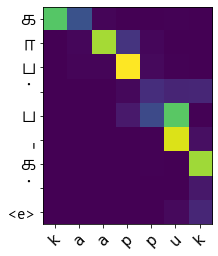

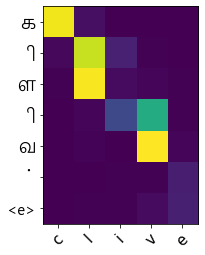

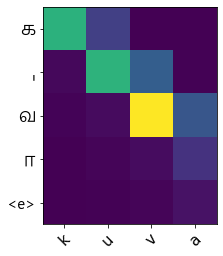

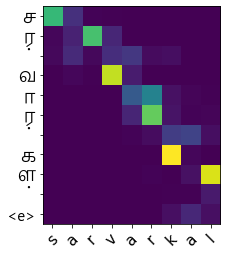

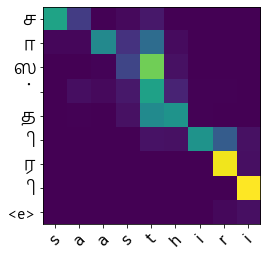

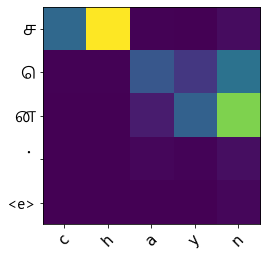

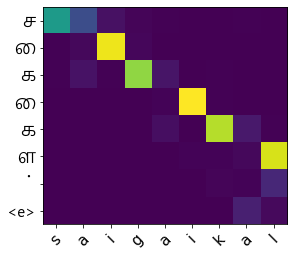

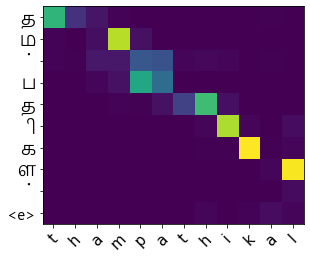

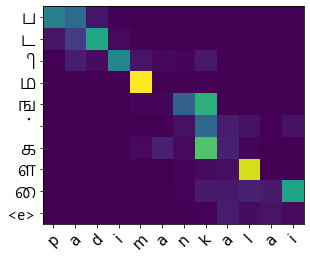

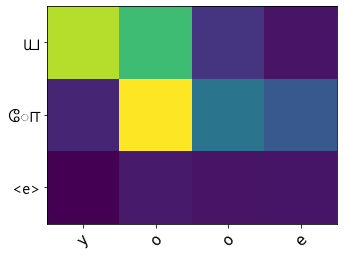

In [ ]:
test_accuracy, heatmaps = infer(model, test_encoder_input_data, test_input_words, test_target_words, num_decoder_tokens, max_decoder_seq_length, target_token_index, reverse_target_char_index, hidden_layer_size, cell_type, for_test = True)

visualize_connectivity(10)
visualize_lstm(10, 0)

In [ ]:
print("Test accuracy is: ", test_accuracy)

Test accuracy is:  0.5667249417249417
